# Diamonds EDA, regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor

from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, OrdinalEncoder

from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

Let's download data and look at it

https://www.kaggle.com/datasets/shivam2503/diamonds?datasetId=1312

In [2]:
diamonds_data = pd.read_csv('/kaggle/input/diamonds/diamonds.csv').drop('Unnamed: 0', axis=1)  # .set_index('Unnamed: 0')
diamonds_data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## EDA

### Shape

In [3]:
diamonds_data.shape

(53940, 10)

### Random strings

In [4]:
diamonds_data.sample(5, random_state=42)

,carat,cut,color,clarity,depth,table,price,x,y,z
1388,0.24,Ideal,G,VVS1,62.1,56.0,559,3.97,4.00,2.47
50052,0.58,Very Good,F,VVS2,60.0,57.0,2201,5.44,5.42,3.26
41645,0.40,Ideal,E,VVS2,62.1,55.0,1238,4.76,4.74,2.95
42377,0.43,Premium,E,VVS2,60.8,57.0,1304,4.92,4.89,2.98
17244,1.55,Ideal,E,SI2,62.3,55.0,6901,7.44,7.37,4.61


### Column types and other info

In [5]:
diamonds_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


### Working with duplicates

Let's count the duplicates

In [6]:
diamonds_data.duplicated().sum()

146

In [7]:
diamonds_data[diamonds_data.duplicated() == True]

,carat,cut,color,clarity,depth,table,price,x,y,z
1005,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
1006,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
1007,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
1008,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
2025,1.52,Good,E,I1,57.3,58.0,3105,7.53,7.42,4.28
...,...,...,...,...,...,...,...,...,...,...
47969,0.52,Ideal,D,VS2,61.8,55.0,1919,5.19,5.16,3.20
49326,0.51,Ideal,F,VVS2,61.2,56.0,2093,5.17,5.19,3.17
49557,0.71,Good,F,SI2,64.1,60.0,2130,0.00,0.00,0.00
50079,0.51,Ideal,F,VVS2,61.2,56.0,2203,5.19,5.17,3.17


Let's delete the duplicates

In [8]:
diamonds_data = diamonds_data.drop_duplicates()

In [9]:
diamonds_data.duplicated().sum()

0

All duplicates were dropped

### Working with NaNs

In [10]:
diamonds_data.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

No NaNs in the dataset

### Исследование числовых признаков (зависимостей)

#### Feature names explanaitions (copied from kaggle)

`price` price in US dollars (326--18,823)

`carat` weight of the diamond (0.2--5.01)

`cut` quality of the cut (Fair, Good, Very Good, Premium, Ideal)

`color` diamond colour, from J (worst) to D (best)

`clarity` a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

`x` length in mm (0--10.74)

`y` width in mm (0--58.9)

`z` depth in mm (0--31.8)

`depth` total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

`table` width of top of diamond relative to widest point (43--95)

In [11]:
diamonds_data.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z'],
      dtype='object')

In [12]:
numerical_columns_and_target = ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']
numerical_columns = ['carat', 'depth', 'table', 'x', 'y', 'z']
categorical_columns = ['cut', 'color', 'clarity']
target_column = 'price'

In [13]:
diamonds_data[numerical_columns].describe()

,carat,depth,table,x,y,z
count,53794.00000,53794.000000,53794.000000,53794.000000,53794.000000,53794.000000
mean,0.79778,61.748080,57.458109,5.731214,5.734653,3.538714
std,0.47339,1.429909,2.233679,1.120695,1.141209,0.705037
min,0.20000,43.000000,43.000000,0.000000,0.000000,0.000000
25%,0.40000,61.000000,56.000000,4.710000,4.720000,2.910000
50%,0.70000,61.800000,57.000000,5.700000,5.710000,3.530000
75%,1.04000,62.500000,59.000000,6.540000,6.540000,4.030000
max,5.01000,79.000000,95.000000,10.740000,58.900000,31.800000


Range of some features differs a lot

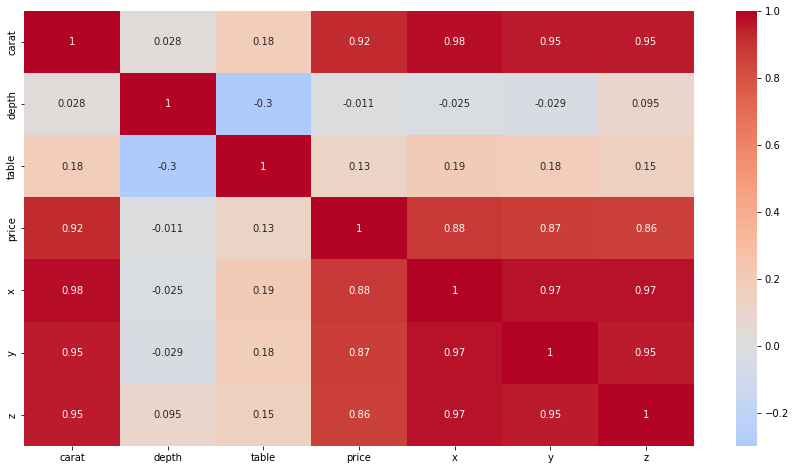

In [14]:
corr_matrix = pd.DataFrame.corr(diamonds_data[numerical_columns_and_target])
plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, center=0);

Features `carat`, `x`, `y`, `z` are highly correlated with each other and with the target column.

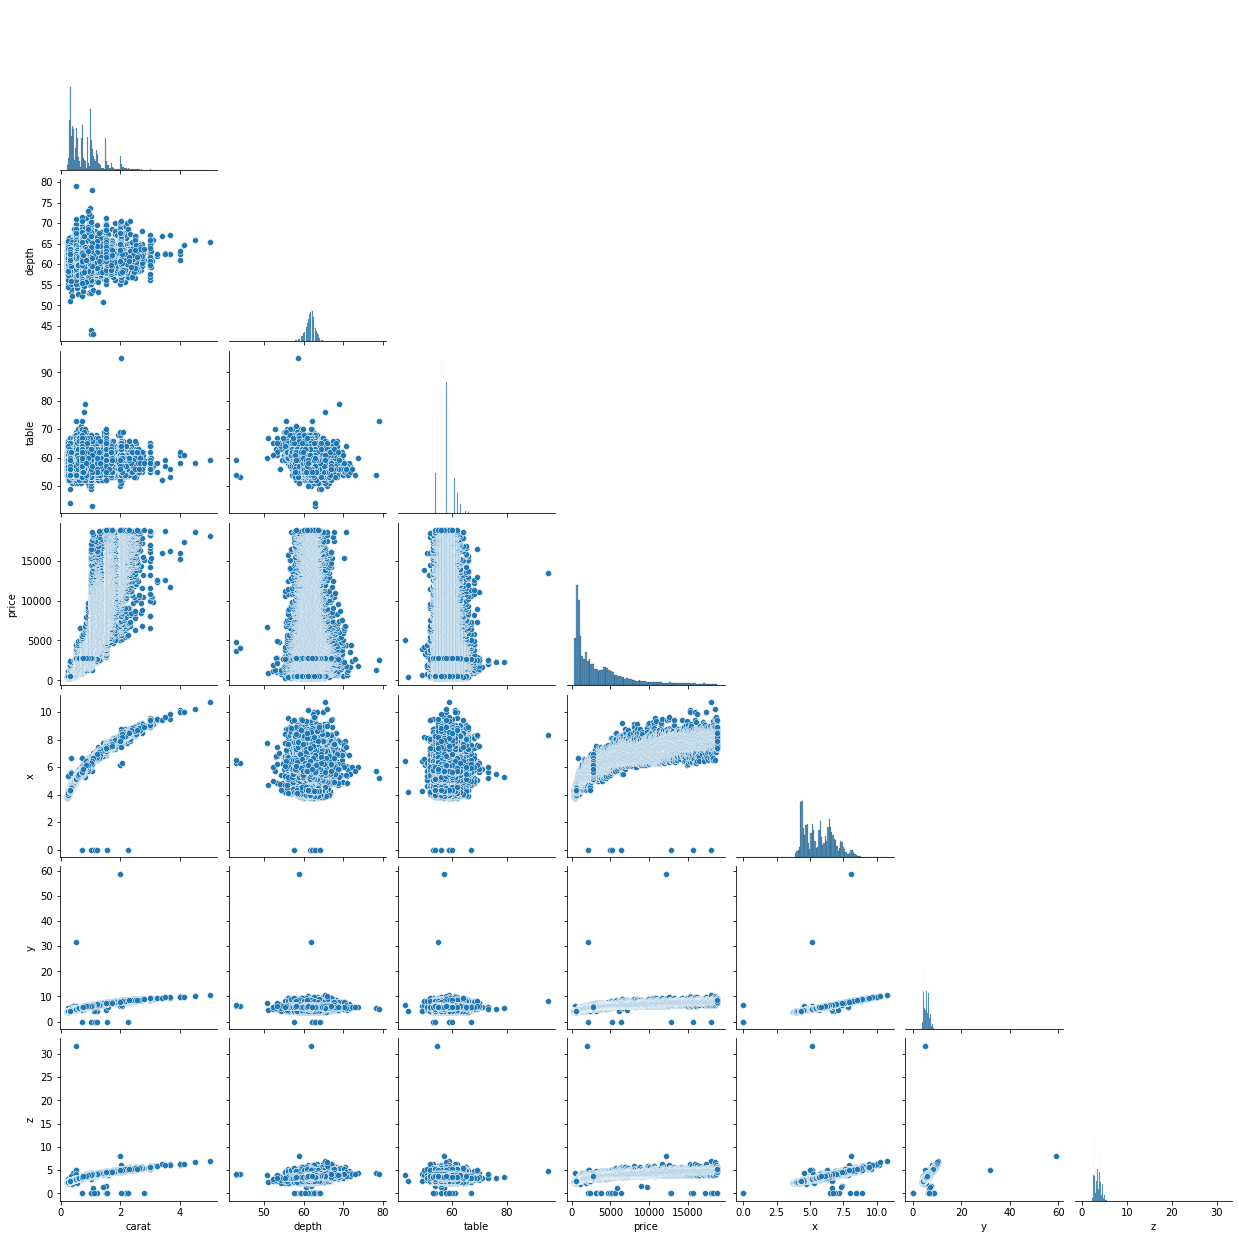

In [15]:
sns.pairplot(diamonds_data[numerical_columns_and_target], corner=True);

### Exploring individual variables

My function

In [16]:
def paint_feature(data_column, is_numerical=True, figsize_=(18, 6), colors_=['cyan', 'deeppink', 'lime', 'coral', 'yellow', 'darkorchid', 'red']):
    fig, axes = plt.subplots(1, 2, figsize=figsize_)
    axes[0].grid(True)
    if is_numerical:
        sns.histplot(ax=axes[0], x=data_column, color='cyan')
        sns.boxplot(ax=axes[1], x=data_column, color='cyan')
    else:
        data_count = data_column.value_counts()
        axes[0].bar(x=data_count.index, height=data_count.values, color=colors_);
        axes[1].pie(labels=data_count.index, x=data_count.values, colors=colors_, autopct='%1.2f%%');

`carat` feature

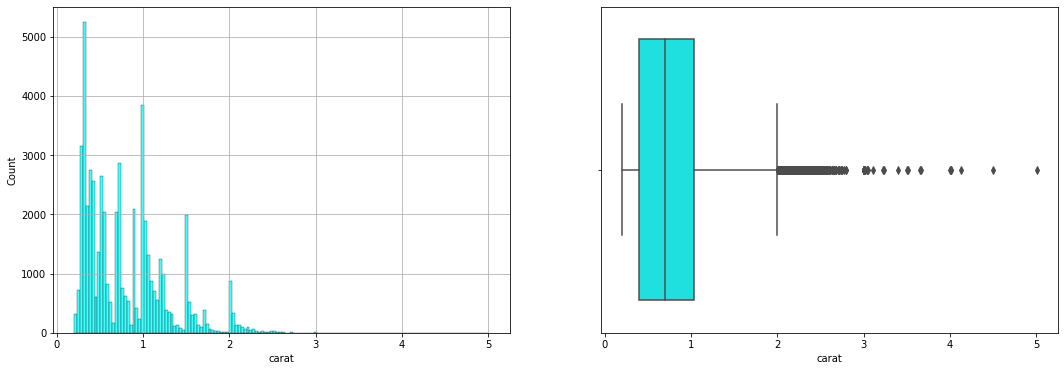

In [17]:
paint_feature(diamonds_data.carat)

`cut` feature

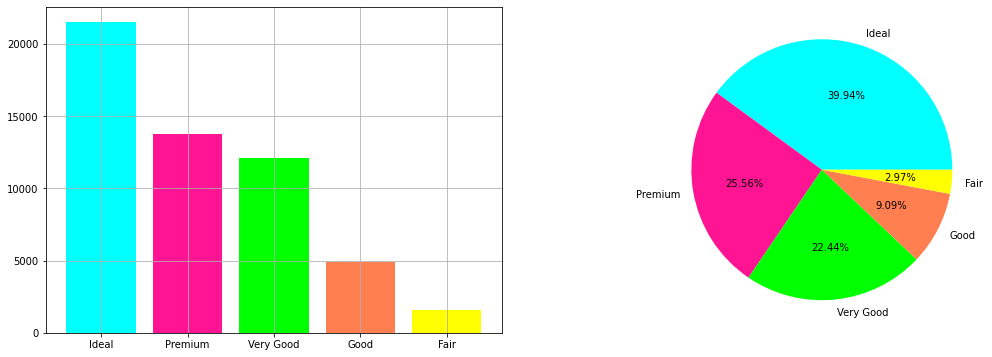

In [18]:
paint_feature(diamonds_data.cut, is_numerical=False)

`color` feature

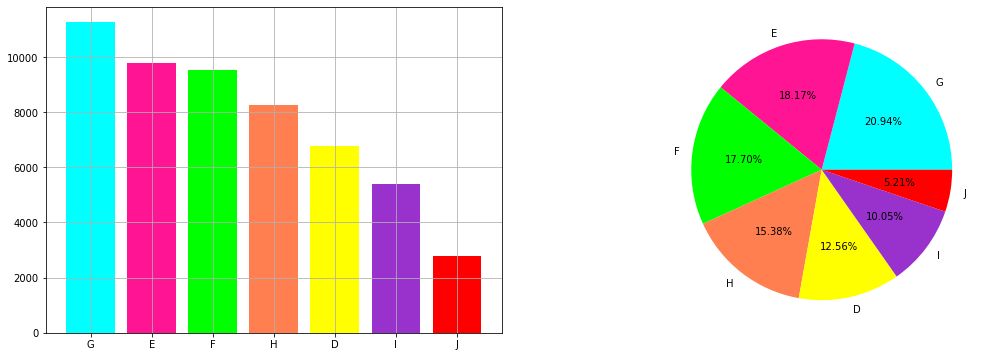

In [19]:
paint_feature(diamonds_data.color, is_numerical=False)

`clarity` feature

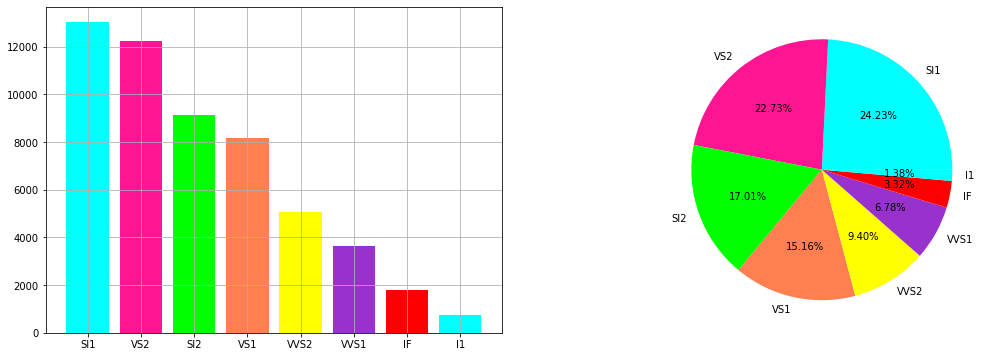

In [20]:
paint_feature(diamonds_data.clarity, is_numerical=False)

`depth` feature

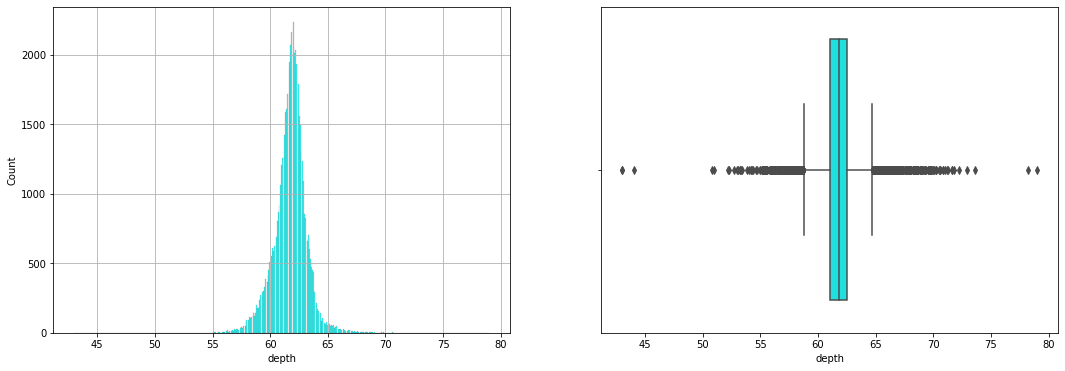

In [21]:
paint_feature(diamonds_data.depth)

`table` feature

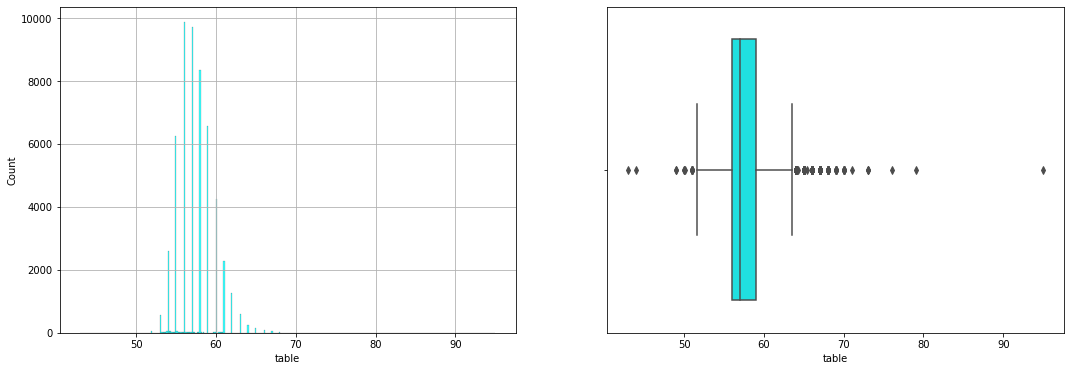

In [22]:
paint_feature(diamonds_data.table)

`price` target

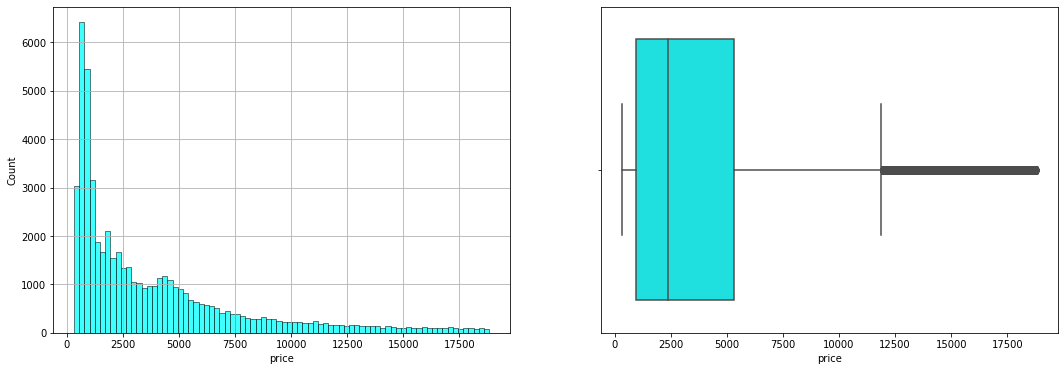

In [23]:
paint_feature(diamonds_data.price)

`x` feature

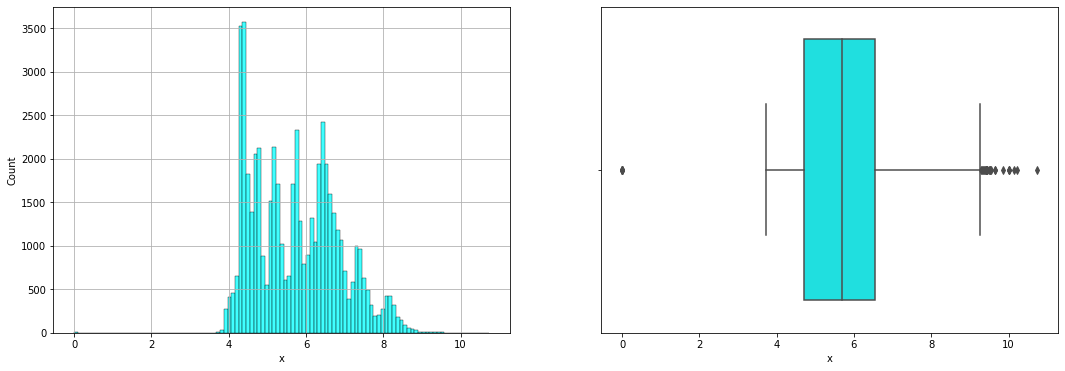

In [24]:
paint_feature(diamonds_data.x)

`y` feature

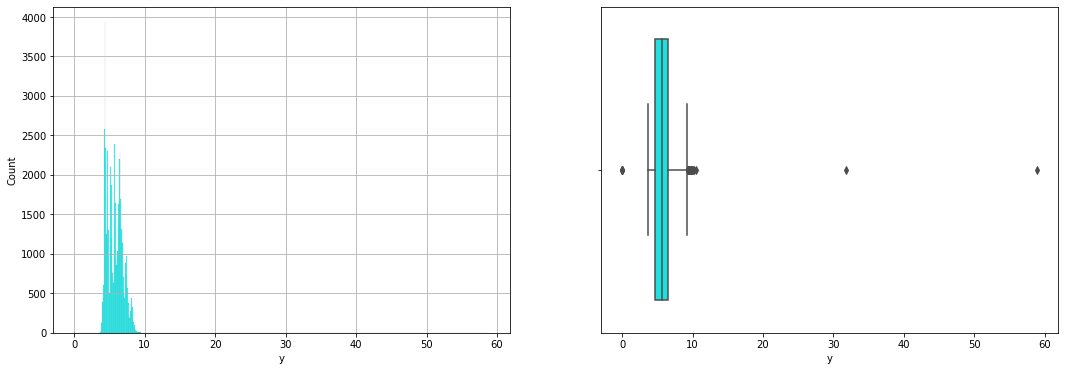

In [25]:
paint_feature(diamonds_data.y)

`z` feature

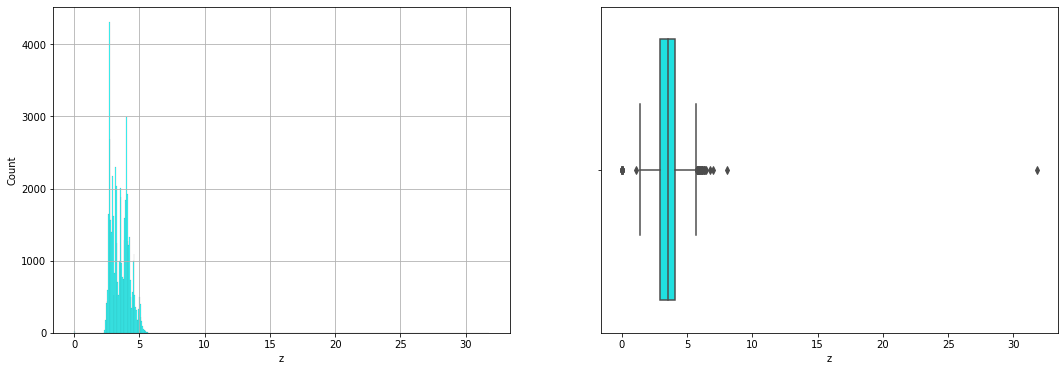

In [26]:
paint_feature(diamonds_data.z)

## Regression

In [27]:
# diamonds_data = pd.read_csv('diamonds.csv').drop('Unnamed: 0', axis=1)  # .set_index('Unnamed: 0')
# diamonds_data = diamonds_data.drop_duplicates()
# diamonds_data

Let's drop highly correlated features

In [28]:
diamonds_data.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z'],
      dtype='object')

In [29]:
diamonds_data = diamonds_data.drop(['x', 'y', 'z'], axis=1)

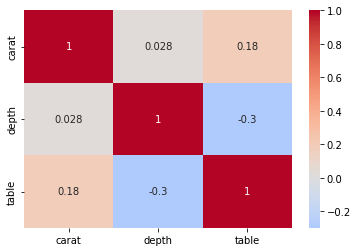

In [30]:
corr_matrix = pd.DataFrame.corr(diamonds_data[['carat', 'depth', 'table']])
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, center=0);

Let's get lists of numerical and categorical variables and divide dataset into features and target.

In [31]:
numerical_features = ['carat', 'depth', 'table']
categorical_features = ['cut', 'color', 'clarity']
X = diamonds_data[['carat', 'depth', 'table', 'cut', 'color', 'clarity']]
y = diamonds_data['price']
display(X.head())
display(y.head())

,carat,depth,table,cut,color,clarity
0,0.23,61.5,55.0,Ideal,E,SI2
1,0.21,59.8,61.0,Premium,E,SI1
2,0.23,56.9,65.0,Good,E,VS1
3,0.29,62.4,58.0,Premium,I,VS2
4,0.31,63.3,58.0,Good,J,SI2


0    326
1    326
2    327
3    334
4    335
Name: price, dtype: int64

### Regression

Train test split 80:20

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

*Quality measurement: MSE, MAE, MAPE, $R^2$*

In [33]:
def count_metrics(y_test, y_pred_test):
    mse_test = mean_squared_error(y_true=y_test, y_pred=y_pred_test)
    mae_test = mean_absolute_error(y_true=y_test, y_pred=y_pred_test)
    mape_test = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_test)
    r2_test = r2_score(y_true=y_test, y_pred=y_pred_test)
    return mse_test, mae_test, mape_test, r2_test

*Idea: to try different regressors with various scalers for numerical features and various encoders.*

#### Encoding only, no scalers

In [34]:
def make_regression_withount_scaling(X_train, X_test, y_train, y_test, 
                    methods={'LinearRegression': LinearRegression, 
                             'Lasso': Lasso, 'Ridge': Ridge,
                             'SGDRegressor': SGDRegressor, 'MLPRegressor': MLPRegressor}, 
                    encoder_=OneHotEncoder, cat_cols=categorical_features):
    metrics_list = []
    s = 20 + 12 + 12 + 10 + 10 + 6
    for i in range(s):
        print('-', end='')
    print()
    print(f'|{"regressor": >20}|{"MSE": >12}|{"MAE": >12}|{"MAPE": >10}|{"R2": >10}|')
    for i in range(s):
        print('-', end='')
    print()
    for method_name, method in methods.items():
        # scaling num features, encoding cat features
        preprocessor = ColumnTransformer(
            transformers=[('cat', encoder_(), cat_cols)], remainder='passthrough')
        # pipeline model
        pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', method())])
        # training model
        pipe.fit(X_train, y_train)
        # predicting
        y_pred = pipe.predict(X_test)
        # counting metrics
        cur_metr = count_metrics(y_test, y_pred)
        print(f'|{method_name: >20}|{cur_metr[0]: >12.3f}|{cur_metr[1]: >12.3f}|{cur_metr[2]: >10.7f}|{cur_metr[3]: >10.7f}|')
    
        metrics_list.append(cur_metr)
    for i in range(s):
        print('-', end='')

OneHotEncoder

In [35]:
make_regression_withount_scaling(X_train, X_test, y_train, y_test)

----------------------------------------------------------------------
|           regressor|         MSE|         MAE|      MAPE|        R2|
----------------------------------------------------------------------
|    LinearRegression| 1279480.095|     787.990| 0.4341201| 0.9160560|
|               Lasso| 1279566.111|     785.281| 0.4290891| 0.9160504|
|               Ridge| 1279514.296|     787.803| 0.4337008| 0.9160538|
|        SGDRegressor|18533351570241.684| 3152015.983|1947.9119532|-1215933.0105623|
|        MLPRegressor|  828437.602|     584.063| 0.3016844| 0.9456480|
----------------------------------------------------------------------

OrdinalEncoder

In [36]:
make_regression_withount_scaling(X_train, X_test, y_train, y_test, encoder_=OrdinalEncoder)

----------------------------------------------------------------------
|           regressor|         MSE|         MAE|      MAPE|        R2|
----------------------------------------------------------------------
|    LinearRegression| 1804499.062|     911.150| 0.4286849| 0.8816106|
|               Lasso| 1804599.252|     910.700| 0.4277261| 0.8816041|
|               Ridge| 1804514.388|     911.093| 0.4285553| 0.8816096|
|        SGDRegressor|802423967552192.250|23141636.094|14396.9281458|-52645338.9073090|
|        MLPRegressor| 1360343.924|     730.658| 0.2831204| 0.9107507|
----------------------------------------------------------------------

*SGDRegressor feels bad without scaling.*

#### Scaling and encoding.

In [37]:
def make_regression(X_train, X_test, y_train, y_test, 
                    methods={'LinearRegression': LinearRegression, 
                             'Lasso': Lasso, 'Ridge': Ridge,
                             'SGDRegressor': SGDRegressor, 'MLPRegressor': MLPRegressor}, 
                    scaler_=StandardScaler, encoder_=OneHotEncoder, 
                    num_cols=numerical_features, cat_cols=categorical_features):
    metrics_list = []
    s = 20 + 12 + 12 + 10 + 10 + 6
    for i in range(s):
        print('-', end='')
    print()
    print(f'|{"regressor": >20}|{"MSE": >12}|{"MAE": >12}|{"MAPE": >10}|{"R2": >10}|')
    for i in range(s):
        print('-', end='')
    print()
    for method_name, method in methods.items():
        # scaling num features, encoding cat features
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', scaler_(), num_cols),
                ('cat', encoder_(), cat_cols)])
        # pipeline model
        pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', method())])
        # training model
        pipe.fit(X_train, y_train)
        # predicting
        y_pred = pipe.predict(X_test)
        # counting metrics
        cur_metr = count_metrics(y_test, y_pred)
        print(f'|{method_name: >20}|{cur_metr[0]: >12.3f}|{cur_metr[1]: >12.3f}|{cur_metr[2]: >10.7f}|{cur_metr[3]: >10.7f}|')
    
        metrics_list.append(cur_metr)
    for i in range(s):
        print('-', end='')

StandardScaler + OneHotEncoder

In [38]:
make_regression(X_train, X_test, y_train, y_test)

----------------------------------------------------------------------
|           regressor|         MSE|         MAE|      MAPE|        R2|
----------------------------------------------------------------------
|    LinearRegression| 1279480.095|     787.990| 0.4341201| 0.9160560|
|               Lasso| 1279522.126|     785.448| 0.4294710| 0.9160533|
|               Ridge| 1279417.222|     788.190| 0.4343566| 0.9160601|
|        SGDRegressor| 1279252.953|     788.458| 0.4356679| 0.9160709|
|        MLPRegressor|  826236.197|     625.763| 0.3364909| 0.9457924|
----------------------------------------------------------------------

MinMaxScaler + OneHotEncoder

In [39]:
make_regression(X_train, X_test, y_train, y_test, scaler_=MinMaxScaler)

----------------------------------------------------------------------
|           regressor|         MSE|         MAE|      MAPE|        R2|
----------------------------------------------------------------------
|    LinearRegression| 1279480.095|     787.990| 0.4341201| 0.9160560|
|               Lasso| 1281871.118|     784.884| 0.4264322| 0.9158991|
|               Ridge| 1279891.741|     786.390| 0.4304327| 0.9160290|
|        SGDRegressor| 1284283.366|     781.084| 0.4179299| 0.9157409|
|        MLPRegressor| 1271391.858|     783.488| 0.4393367| 0.9165867|
----------------------------------------------------------------------

RobustScaler + OneHotEncoder

In [40]:
make_regression(X_train, X_test, y_train, y_test, scaler_=RobustScaler)

----------------------------------------------------------------------
|           regressor|         MSE|         MAE|      MAPE|        R2|
----------------------------------------------------------------------
|    LinearRegression| 1279480.096|     787.990| 0.4341201| 0.9160560|
|               Lasso| 1279541.421|     785.400| 0.4293486| 0.9160520|
|               Ridge| 1279533.709|     787.833| 0.4337021| 0.9160525|
|        SGDRegressor| 1281619.092|     784.179| 0.4259622| 0.9159157|
|        MLPRegressor|  671652.179|     537.016| 0.2765599| 0.9559343|
----------------------------------------------------------------------

StandardScaler + OrdinalEncoder

In [41]:
make_regression(X_train, X_test, y_train, y_test, encoder_=OrdinalEncoder)

----------------------------------------------------------------------
|           regressor|         MSE|         MAE|      MAPE|        R2|
----------------------------------------------------------------------
|    LinearRegression| 1804499.062|     911.150| 0.4286849| 0.8816106|
|               Lasso| 1804572.019|     910.822| 0.4280215| 0.8816058|
|               Ridge| 1804502.769|     911.136| 0.4286539| 0.8816104|
|        SGDRegressor| 1820046.521|     901.921| 0.4446616| 0.8805906|
|        MLPRegressor| 1085716.021|     594.383| 0.1856518| 0.9287685|
----------------------------------------------------------------------

MinMaxScaler + OrdinalEncoder

In [42]:
make_regression(X_train, X_test, y_train, y_test, scaler_=MinMaxScaler, encoder_=OrdinalEncoder)

----------------------------------------------------------------------
|           regressor|         MSE|         MAE|      MAPE|        R2|
----------------------------------------------------------------------
|    LinearRegression| 1804499.062|     911.150| 0.4286849| 0.8816106|
|               Lasso| 1807529.959|     908.753| 0.4230658| 0.8814118|
|               Ridge| 1805048.917|     909.731| 0.4254876| 0.8815746|
|        SGDRegressor| 1821200.796|     897.140| 0.4244629| 0.8805149|
|        MLPRegressor| 1732528.727|     905.657| 0.4246531| 0.8863325|
----------------------------------------------------------------------

RobustScaler + OrdinalEncoder

In [43]:
make_regression(X_train, X_test, y_train, y_test, scaler_=RobustScaler, encoder_=OrdinalEncoder)

----------------------------------------------------------------------
|           regressor|         MSE|         MAE|      MAPE|        R2|
----------------------------------------------------------------------
|    LinearRegression| 1804499.062|     911.150| 0.4286849| 0.8816106|
|               Lasso| 1804596.376|     910.762| 0.4278896| 0.8816042|
|               Ridge| 1804505.626|     911.126| 0.4286302| 0.8816102|
|        SGDRegressor| 1809360.322|     911.172| 0.4276489| 0.8812917|
|        MLPRegressor| 1104095.391|     620.309| 0.2117530| 0.9275626|
----------------------------------------------------------------------